# Knapsack

In [1]:
title = 'Knapsack'

In [2]:
import mlrose_hiive

import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
eval_count = 0

def knapsack(state, weights, values, max_weight_pct):
    global eval_count
    
    fitness = mlrose_hiive.Knapsack(weights, values, max_weight_pct)
    
    eval_count += 1
    
    return fitness.evaluate(state)

## test
w = [10, 5, 2, 8, 15]
v = [1, 2, 3, 4, 5]
max_w_pct = 0.6

state = np.array([1, 0, 2, 1, 0])
print('Knapsack:', knapsack(state, w, v, max_w_pct))

kwargs = {'weights':w, 'values':v, 'max_weight_pct':max_w_pct}
ffn_knapsack = mlrose_hiive.CustomFitness(knapsack, **kwargs)
state = np.array([1, 0, 2, 1, 0])
print('Custom Knapsack:', ffn_knapsack.evaluate(state))


Knapsack: 11
Custom Knapsack: 11


In [87]:
np.random.seed(1)
input_size = [10, 20, 25, 150]

eval_cnt_df = pd.DataFrame()
eval_cnt_df['input_size'] = input_size
eval_cnt_rhc = []
eval_cnt_sa = []
eval_cnt_ga = []
eval_cnt_mimic = []

eval_time_df = pd.DataFrame()
eval_time_df['input_size'] = input_size
eval_time_rhc = []
eval_time_sa = []
eval_time_ga = []
eval_time_mimic = []

fitness_curve = {}

schedule=mlrose_hiive.ExpDecay() ## Simulated Annealing
# schedule=mlrose_hiive.ExpDecay(exp_const=.001, init_temp=2)

for n in input_size:
    np.random.seed(1)
    ## initialize problem
    number_of_items_types=n  ## number of inputs    
    max_weight_per_item=25
    max_value_per_item=10 
    max_weight_pct=0.6
    weights = 1 + np.random.randint(max_weight_per_item, size=number_of_items_types)
    values  = 1 + np.random.randint(max_value_per_item, size=number_of_items_types)

    kwargs = {'weights':weights, 'values':values, 'max_weight_pct':max_weight_pct}
    ffn_knapsack = mlrose_hiive.CustomFitness(knapsack, **kwargs)

    init_state = np.random.randint(2, size=n)

    problem = mlrose_hiive.DiscreteOpt(length=len(init_state), fitness_fn=ffn_knapsack, 
                                       maximize=True, max_val=2)
    
    print('Custom Knapsack:', ffn_knapsack.evaluate(init_state))
    
    ## Random Hill Climbing
    eval_count = 0
    begin = datetime.now()
    rhc_state, rhc_fitness, rhc_curve = mlrose_hiive.random_hill_climb(problem, 
                                                                       max_attempts=100, 
                                                                       max_iters=6000,
                                                                       restarts=200,
                                                                       init_state=init_state,
                                                                       curve=True)
    end = datetime.now()
    
    dt = end - begin
    eval_time_rhc.append(dt.total_seconds())
    eval_cnt_rhc.append(eval_count)

    ## Simulated Annealing
    eval_count = 0
    schedule = mlrose_hiive.GeomDecay(init_temp=5.0) ## Simulated Annealing
    begin = datetime.now()
    sa_state, sa_fitness, sa_curve = mlrose_hiive.simulated_annealing(problem,
                                                                      schedule=schedule,
                                                                      max_attempts=100, 
                                                                      max_iters=4096, 
                                                                      init_state=init_state,
                                                                      curve=True)
    end = datetime.now()
    
    dt = end - begin
    eval_time_sa.append(dt.total_seconds())
    eval_cnt_sa.append(eval_count)
    
    ## Genetic Algorithm
    eval_count = 0
    pop_size = 150
    mute_prob = 0.1
    begin = datetime.now()
    ga_state, ga_fitness, ga_curve =  mlrose_hiive.genetic_alg(problem, 
                                                               pop_size=pop_size,
                                                               mutation_prob=mute_prob, 
                                                               max_attempts=50,
                                                               max_iters=256,
                                                               curve=True)
    end = datetime.now()
    
    dt = end - begin
    eval_time_ga.append(dt.total_seconds())
    eval_cnt_ga.append(eval_count)
    
    ## MIMIC
    eval_count = 0
    pop_size = 750
    keep_pct = 0.5
    begin = datetime.now()
    mimic_state, mimic_fitness, mimic_curve = mlrose_hiive.mimic(problem, 
                                                                 pop_size=pop_size,
                                                                 keep_pct=keep_pct, 
                                                                 max_attempts=50,
                                                                 max_iters=128,
                                                                 curve=True)
    end = datetime.now()
    
    dt = end - begin
    eval_time_mimic.append(dt.total_seconds())
    eval_cnt_mimic.append(eval_count)


fitness_curve['rhc'] = rhc_curve
eval_cnt_df['rhc'] = eval_cnt_rhc
eval_time_df['rhc'] = eval_time_rhc

fitness_curve['sa']  = sa_curve
eval_cnt_df['sa']  = eval_cnt_sa
eval_time_df['sa']  = eval_time_sa

fitness_curve['ga']  = ga_curve
eval_cnt_df['ga']  = eval_cnt_ga
eval_time_df['ga']  = eval_time_ga

fitness_curve['mimic'] = mimic_curve
eval_cnt_df['mimic'] = eval_cnt_mimic
eval_time_df['mimic'] = eval_time_mimic

Custom Knapsack: 0
Custom Knapsack: 59
Custom Knapsack: 78
Custom Knapsack: 364


In [88]:
# Custom Knapsack: 0
# Custom Knapsack: 59
# Custom Knapsack: 78
# Custom Knapsack: 137

In [89]:
eval_cnt_df

,input_size,rhc,sa,ga,mimic
0,10,22926,264,7853,39805
1,20,23691,344,9669,43564
2,25,26210,335,11633,44315
3,150,38185,408,23890,68368


In [90]:
eval_time_df

,input_size,rhc,sa,ga,mimic
0,10,1.309092,0.016572,0.744079,3.020208
1,20,1.446301,0.022258,0.894468,9.333446
2,25,1.597248,0.022138,1.097659,14.121835
3,150,3.236339,0.037090,3.472758,758.013604


In [92]:
print(title + ' (%d bit)\tstate'%len(rhc_state))
print('rhc:   {0:4.1f} []'.format(rhc_fitness, ''.join(str(x) for x in rhc_state)))
print('sa:    {0:4.1f} []'.format(sa_fitness, ''.join(str(x) for x in sa_state)))
print('ga:    {0:4.1f} []'.format(ga_fitness, ''.join(str(x) for x in ga_state)))
print('mimic: {0:4.1f} []'.format(mimic_fitness, ''.join(str(x) for x in mimic_state)))

Knapsack (150 bit)	state
rhc:   505.0 []
sa:    537.0 []
ga:    690.0 []
mimic: 690.0 []


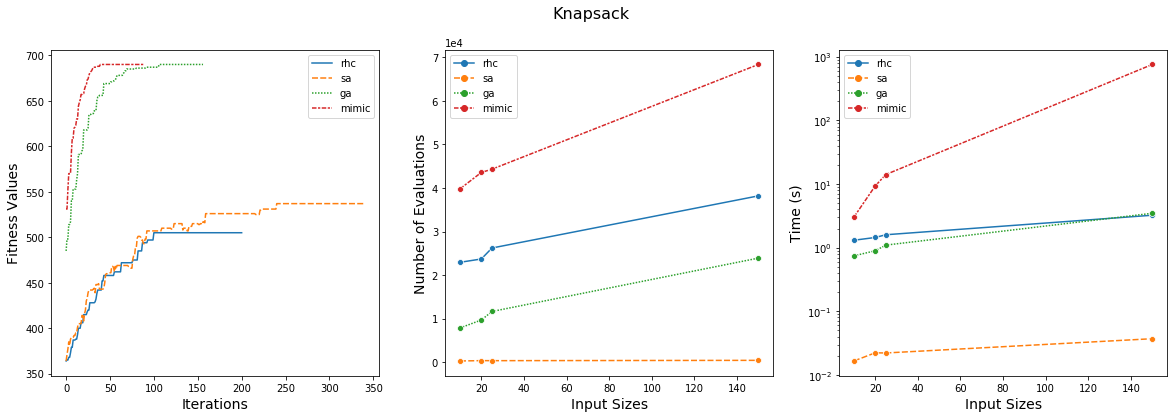

In [93]:
fig = plt.figure(figsize=(20,6))
# fig, axes = plt.subplots(1, 3, figsize=(20,4))
fig.suptitle(title, fontsize=16)

## evaluation number
df = eval_cnt_df.set_index('input_size')
ax = fig.add_subplot(132)
ax = sns.lineplot(data=df, markers=['o']*4,)
ax.ticklabel_format(axis='y', style='sci',  scilimits=(0,0))
ax.set_xlabel('Input Sizes', fontsize=14)
ax.set_ylabel('Number of Evaluations',fontsize=14)

## time
df = eval_time_df.set_index('input_size')
ax = fig.add_subplot(133)
ax = sns.lineplot(data=df, markers=['o']*4)
ax.set_yscale('log')
ax.set_xlabel('Input Sizes', fontsize=14)
ax.set_ylabel('Time (s)', fontsize=14)

## Fitness Convergence Analysis
labels = ['rhc', 'sa', 'ga', 'mimic']
az = fig.add_subplot(131)
ax = sns.lineplot(data=[rhc_curve, sa_curve, ga_curve, mimic_curve])
# ax.set_ylim(0, 36)
ax.set_xlabel('Iterations', fontsize=14)
ax.set_ylabel('Fitness Values', fontsize=14)
legend = ax.get_legend()
for handle,l in zip(legend.texts, labels):
    handle.set_text(l)

# plt.tight_layout(True)

[Text(0, 0.5, 'Number of Evaluations'), Text(0.5, 0, 'Input Sizes')]

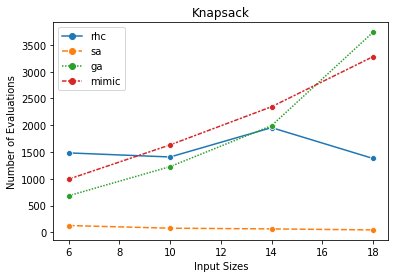

In [77]:
df = eval_cnt_df.set_index('input_size')
ax = sns.lineplot(data=df, markers=['o']*4)

ax.set_title(title)
ax.set(xlabel='Input Sizes',ylabel='Number of Evaluations')

[Text(0, 0.5, 'Time (s)'), Text(0.5, 0, 'Input Sizes')]

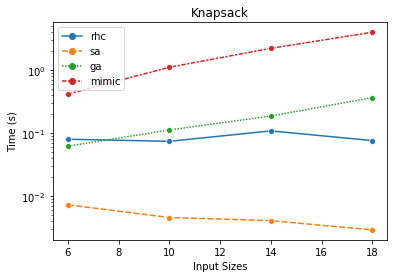

In [79]:
df = eval_time_df.set_index('input_size')
ax = sns.lineplot(data=df, markers=['o']*4)

ax.set_title(title)
ax.set_yscale('log')
ax.set(xlabel='Input Sizes', ylabel='Time (s)')

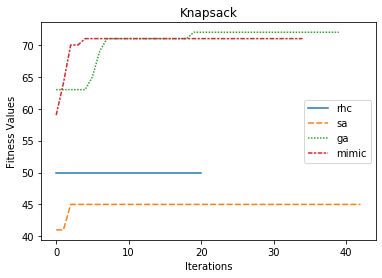

In [73]:
## Fitness Convergence Analysis
labels = ['rhc', 'sa', 'ga', 'mimic']

ax = sns.lineplot(data=[rhc_curve, sa_curve, ga_curve, mimic_curve])
# ax.set_ylim(0, 36)
ax.set_title(title)
ax.set(xlabel='Iterations',ylabel='Fitness Values')

legend = ax.get_legend()
for handle,l in zip(legend.texts, labels):
    handle.set_text(l)
